# Using the ARIMA model to forecast CO_2 data 

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64


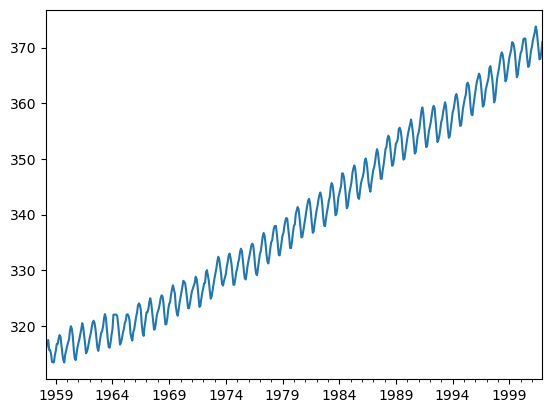

In [1]:
# impoert necessary modules and clean data
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

db = sm.datasets.co2.load_pandas()
y = db.data

''' resampling data from weekly intervals to monthly intrvals by taking the mean of that month'''
y = y['co2'].resample('MS').mean()
y = y.fillna(y.bfill()) #filling NaN entries by using the next valid entry
print (y)
y.plot()
plt.show()

In [2]:
''' Using ARIMA to forecast CO_2 data'''
# we use seasonal ARIMA (SARIMAX) and tune it's hyperparamters first
# we have p,d,q the paramaters of ARIMA and the seasonal parameters P,D,Q
# define all combinations of seasonal and non seasonal parameters

p = d = q = P = D = Q = [0,1]

pdq = list(itertools.product(p, d, q))
PDQ = list(itertools.product(p, d, q,[12]))

# Now we find the optimal combination of parameters using the AIC score (high accuracy with less parameters)
warnings.filterwarnings("ignore")

model_score =[]

for i in pdq:
    for j in PDQ:
        ARIMA = sm.tsa.statespace.SARIMAX(y, order = i, seasonal_order = j, enforce_stationarity = False, enforce_invertibility=False)
        res = ARIMA.fit()
        model_score.append([i,j,res.aic]) 

optimal = model_score[0]
for k in range(len(model_score)):
    if model_score[k][2]< optimal[2] :
        optimal = model_score[k]
        print (optimal)

print ("The final optimal value is:",optimal)
    

[(0, 0, 0), (0, 0, 1, 12), 6787.343624034713]
[(0, 0, 0), (0, 1, 0, 12), 1854.8282341411793]
[(0, 0, 0), (0, 1, 1, 12), 1596.7111727643291]
[(0, 0, 0), (1, 0, 0, 12), 1058.938892132006]
[(0, 0, 0), (1, 0, 1, 12), 1056.2878474463107]
[(0, 0, 0), (1, 1, 1, 12), 1044.764791303649]
[(0, 0, 1), (1, 0, 1, 12), 780.4309449894783]
[(0, 1, 0), (0, 1, 0, 12), 633.4425587879977]
[(0, 1, 0), (0, 1, 1, 12), 337.7938548206756]
[(0, 1, 0), (1, 1, 1, 12), 323.3246648635563]
[(0, 1, 1), (0, 1, 1, 12), 302.4949000020116]
[(0, 1, 1), (1, 1, 1, 12), 281.51901818512516]
[(1, 1, 1), (1, 1, 1, 12), 277.7802198680198]
The final optimal value is: [(1, 1, 1), (1, 1, 1, 12), 277.7802198680198]


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.441      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.162      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.812      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.633      0.000       0.089       0.106


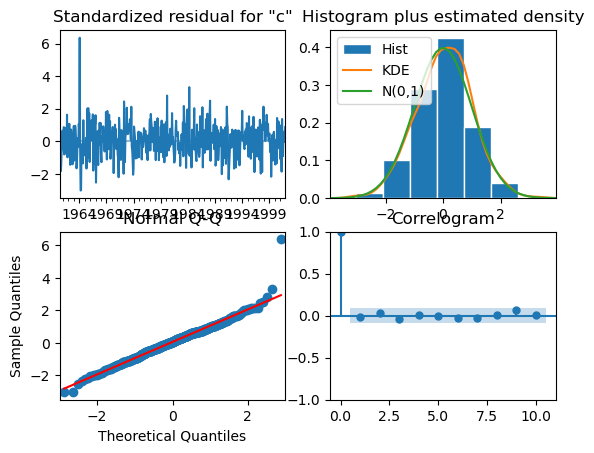

In [3]:
''' Training the model using the optimal hyperparameter value '''

ARIMA = sm.tsa.statespace.SARIMAX(y,order=(1, 1, 1),seasonal_order=(1, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False)

results = ARIMA.fit()

print(results.summary().tables[1])
results.plot_diagnostics()
plt.show()

# The above diagnosis confirms that our data error is invariant on time and normally distributed which means that our model will yield accurate predictions.

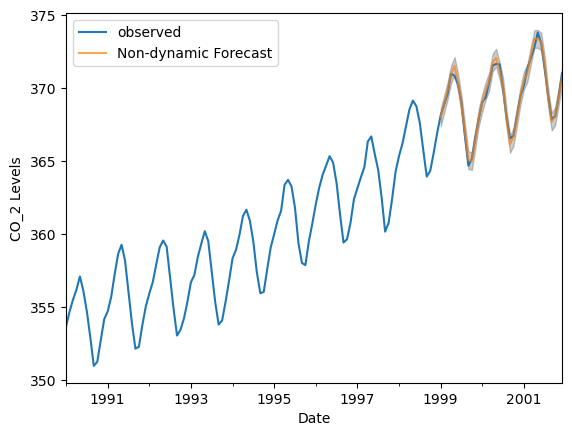

The MSE of the prediction is: 0.07261293095512776


In [31]:
''' forecasting using the model and checking for accuracy '''
import math

pred = results.get_prediction(start=pd.to_datetime('1999-01-01'), dynamic=False)
pred_ci = pred.conf_int() # confidence interval of prediction

ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Non-dynamic Forecast', alpha=.7)

ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO_2 Levels')
plt.legend()

plt.show()

''' measuring accuracy using MSE'''

print("The MSE of the prediction is:",((pred.predicted_mean - y['1999-01-01':])**2).mean())

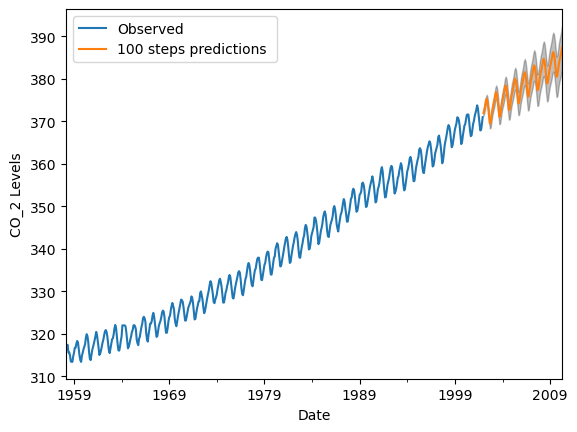

In [37]:
''' Predicting future CO_2 using the model'''
pred_future = results.get_forecast(steps = 100)
pred_future_ci = pred_future.conf_int()

ax = y.plot(label='Observed')

pred_future.predicted_mean.plot(ax=ax, label='100 steps predictions ')

ax.fill_between(pred_future_ci.index,pred_future_ci.iloc[:, 0],pred_future_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO_2 Levels')

plt.legend()
plt.show()
